<a href="https://colab.research.google.com/github/AshishRaj04/backpropagation-and-neural-network-implementation-from-scratch/blob/main/backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Building a Simple Autograd Engine

This code defines a `Value` class to represent nodes in a computation graph. It implements basic arithmetic operations (`+`, `*`, `-`, `/`) and the `tanh` activation function. Each operation creates a new `Value` object and defines a `_backward` function to calculate gradients during backpropagation.

In [ ]:
class Value():
  def __init__(self , data , _children=() , _op = "" , _label = ""):
    self.data = data
    self._backward = lambda: None
    self._prev = set(_children) # stores the previous two operands
    self.grad = 0 # Default the gradient is zero
    self._op = _op # stores the last operator
    self._label = _label
  def __repr__(self):
    return f"Value(data={self.data})"
  def __add__(self,other): # if a and b are Value objects then python will evaluate a + b as  a.__add__(b) . a = self , b = other
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data + other.data , (self , other) , "+")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  def __mul__(self,other): # a.__mul__(b)
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data * other.data , (self , other) , "*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  def __sub__(self , other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data - other.data , (self , other) , "-")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += -1.0 * out.grad
    out._backward = _backward
    return out
  def __truediv__(self , other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data / other.data , (self , other) , "/")
    def _backward():
      self.grad += 1.0 / other.data * out.grad
      other.grad += -self.data / other.data**2 * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def tanh(self):
       x = self.data
       t = (np.exp(2*x)-1)/(np.exp(2*x)+1)
       out = Value(t , (self ,) , 'tanh')
       def _backward():
         self.grad += (1-t**2) * out.grad
       out._backward = _backward
       return out

  def exp(self):
    x = self.data
    out = Value(np.exp(x) , (self , ) , 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def pow(self,other):
    assert isinstance(other , (int,float)) # If the condition (isinstance(other, (int, float))) is False, the program raises an AssertionError. This prevents the function from running with invalid input, ensuring other is always a valid exponent.
    x = self.data
    out = Value(x**other , (self , ) , f'**{other}')
    def _backward():
      self.grad += other * x**(other - 1) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    stack = []
    visited = set()

    def dfs(node):
      if node  in visited:
        return
      visited.add(node)
      for child in node._prev:
        dfs(child)
      stack.append(node)

    dfs(self)
    self.grad = 1.0
    for node in stack[::-1]:
      node._backward()



# Creating a Computation Graph

This cell demonstrates how to create a simple computation graph using the `Value` objects. It defines variables (`a`, `b`, `c`, `e`, `f`, `g`, `h`, `I`) and performs operations on them to build the graph. The output shows the final value of `I` and its previous nodes/operation.

In [ ]:
a = Value(2 , _label = 'a')
b = Value(-3 , _label = 'b')
c = Value(10 , _label = 'c')
e = a*b ; e._label = 'e'
f = e - c ; f._label = 'f'
g = f + a ; g._label = 'g'
h = Value(-2 , _label='h')
I = g * h ; I._label = 'I'
I

Value(data=28)

In [ ]:
I._prev , I._op

({Value(data=-14), Value(data=-2)}, '*')

# Manual gradient calculation.

 Manually calculating the gradient for each node in the computation graph.

In [ ]:
dI_dI = 1
dI_dg = -2
dI_dh = -14
dI_df = -2
dI_db = -4
dI_dc = 2
dI_de = -2
dI_da = 4

I.grad = 1
g.grad = -2
h.grad = -14
f.grad = -2
b.grad = -4
c.grad = 2
e.grad = -2
a.grad = 4

# Visualizing the Computation Graph

This cell uses the graphviz library to visualize the computation graph. It defines a draw_computation_graph function that takes the root node as input and generates a Graphviz representation of the graph. The output displays the graph, providing a clear view of the node connections and operations.

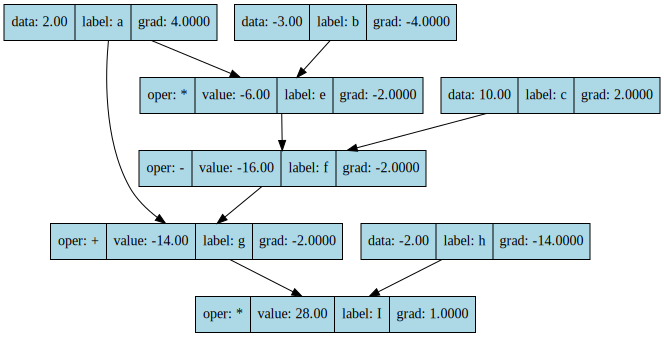

In [ ]:
from graphviz import Digraph
from IPython.display import display

def draw_computation_graph(root):
    """Generates a Graphviz computation graph and displays it."""
    dot = Digraph(format='png', graph_attr={'rankdir': 'TB'})  # Top to Bottom layout

    def add_nodes_edges(node):
        """Recursive function to add nodes and edges."""
        if node not in visited:
            visited.add(node)
            node_id = str(id(node))

            # Node label with operation if applicable
            label = f"data: {node.data:.2f} |\n label: {node._label} | \n grad: {node.grad:.4f}"
            if node._op:
                label = f"oper: {node._op} | \n value: {node.data:.2f} | \n label: {node._label} | \n grad: {node.grad:.4f}"
            dot.node(node_id, label, shape="record", style="filled", fillcolor="lightblue")

            # Add edges for previous nodes
            for child in node._prev:
                child_id = str(id(child))
                dot.edge(child_id, node_id)
                add_nodes_edges(child)

    visited = set()
    add_nodes_edges(root)
    return dot


dot = draw_computation_graph(I)
display(dot)

In [ ]:
I.grad = 1
g.grad = 0
h.grad = 0
f.grad = 0
b.grad = 0
c.grad =0
e.grad = 0
a.grad =0

In [ ]:
I._backward()
g._backward()
h._backward()
f._backward()
b._backward()
c._backward()
e._backward()
a._backward()

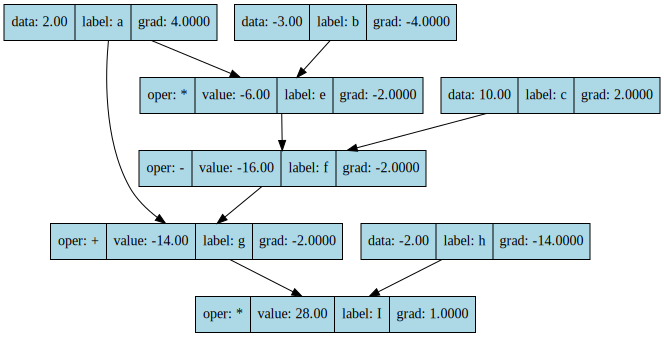

In [ ]:
dot = draw_computation_graph(I)
display(dot)

In [ ]:
I.grad = 1
g.grad = 0
h.grad = 0
f.grad = 0
b.grad = 0
c.grad =0
e.grad = 0
a.grad =0

In [ ]:
I.backward()

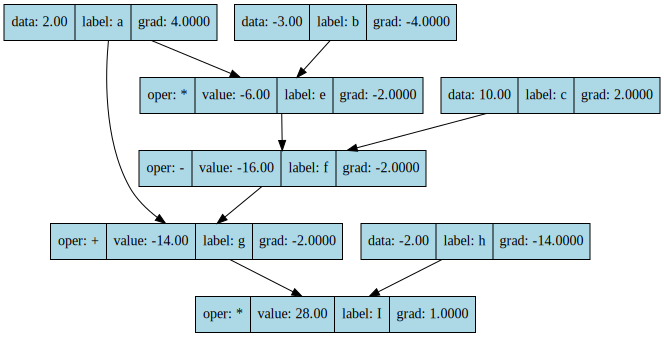

In [ ]:
dot = draw_computation_graph(I)
display(dot)

# A simple one unit neural network

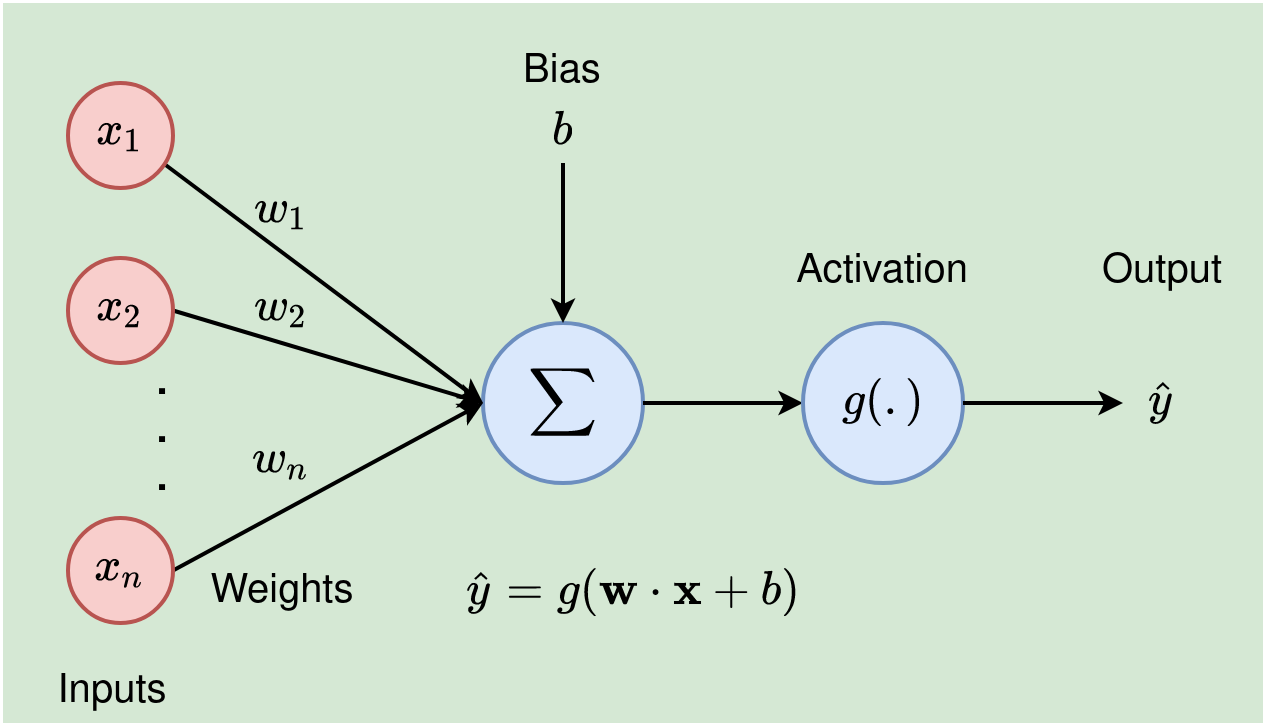

# Visualizing the tanh Activation Function

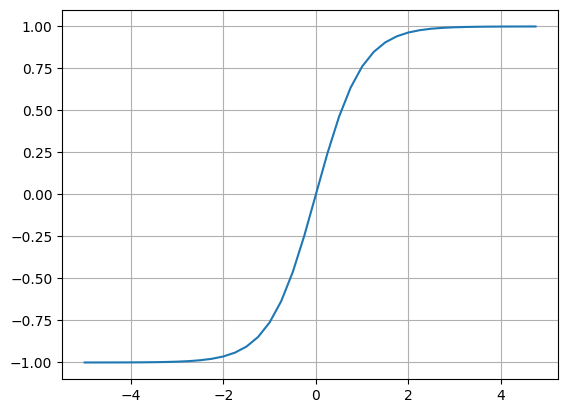

In [ ]:
xs = np.arange(-5,5,0.25)
ys = np.tanh(xs)
plt.plot(xs,ys)
plt.grid()

# Building a Single Neuron Model
This cell builds a simple single-neuron model using the Value objects. It defines input values (x1, x2, x3), weights (w1, w2, w3), and a bias (b). It then performs a series of operations to calculate the weighted sum of inputs, add the bias, and apply the tanh activation function. The output represents the activation of the neuron.

In [ ]:
x1 = Value(2 , _label='x1')
x2 = Value(3 , _label='x2')
x3 = Value(5 , _label='x3')

w1 = Value(0.5 , _label='w1')
w2 = Value(0.2 , _label='w2')
w3 = Value(0.7 , _label='w3')

b = Value(-4.7 , _label='b')

x1w1 = x1*w1 ; x1w1._label = 'x1w1'
x2w2 = x2*w2 ; x2w2._label = 'x2w2'
x3w3 = x3*w3 ; x3w3._label = 'x3w3'

x = x1w1 + x2w2  ; x._label = 'x'

y = x + x3w3  ; y._label = 'y'

z = y + b ; z._label = 'z'

a = z.tanh() ; a._label = 'a'



# METHOD 1
## Manually calculating the gradient for each node

In [ ]:
a.grad = 1.0
z.grad = 0.8556
y.grad = 0.8556
b.grad = 0.8556
x.grad = 0.8556
x3w3.grad = 0.8556
x2w2.grad = 0.8556
x1w1.grad = 0.8556
w3.grad = 4.2782
w2.grad = 2.5669
w1.grad = 1.7113
x1.grad = 0.4278
x2.grad = 0.1711
x3.grad = 0.5989

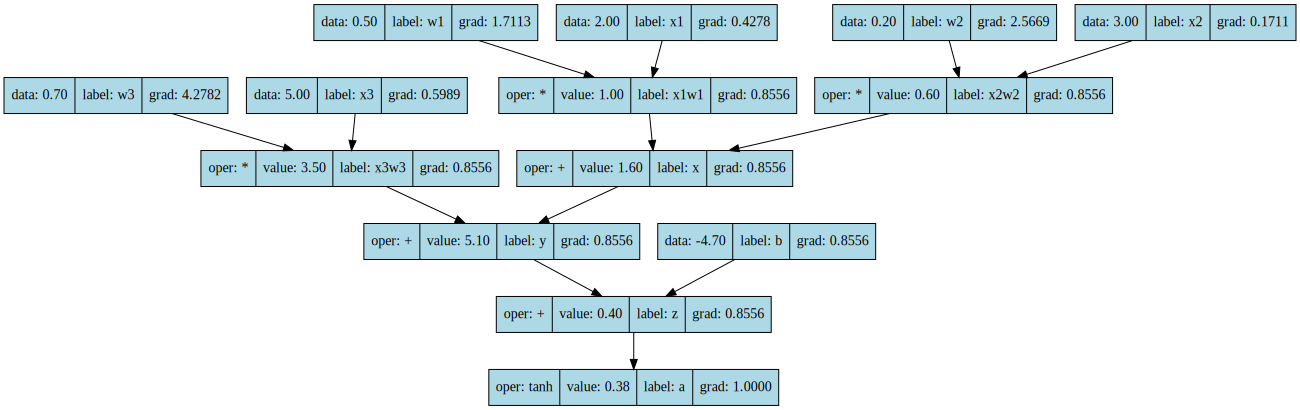

In [ ]:
dot = draw_computation_graph(a)
display(dot)

# Intutions
- Here we have only single neuron
- In NN setup what we really care about is the derivative of a wrt weights and bias
- **Tip:** a plus(+) node is just a distrubuter of the gradient


# Setting the gradient to zero except the gradient of a which is set to one.

In [ ]:
a.grad = 1 # Very important to put this base case manually
z.grad = 0
y.grad = 0
b.grad = 0
x.grad = 0
x3w3.grad = 0
x2w2.grad = 0
x1w1.grad = 0
w3.grad = 0
w2.grad = 0
w1.grad = 0
x1.grad = 0
x2.grad = 0
x3.grad = 0

# METHOD 2
## Manually calling the ._backward() method to compute the gradient

In [ ]:
a._backward()
z._backward()
y._backward()
b._backward()
x._backward()
x3w3._backward()
x2w2._backward()
x1w1._backward()

**Result**
- This way we got the same gradients .
- Now we will work on removing the manual calling of ._backward() method .

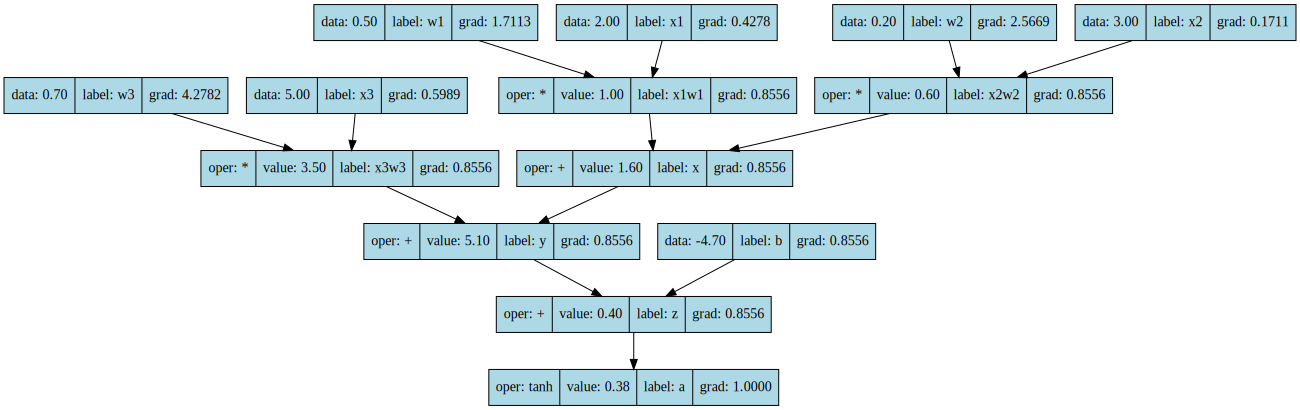

In [ ]:
dot = draw_computation_graph(a)
display(dot)

# Topological Sorting using Depth-First Search (DFS)
Topological sorting is a linear ordering of vertices in a directed acyclic graph (DAG), where for every directed edge U → V, node U appears before node V in the ordering. This is commonly used in task scheduling, dependency resolution, and compiler optimization.

## Example Graph Representation

We represent the computational graph as a dictionary where:
- Keys represent nodes.
- Values (lists) represent outgoing edges (dependencies).


```
graph = {
    'A': ['C'],
    'B': ['C', 'D'],
    'C': ['E'],
    'D': ['F'],
    'E': ['H', 'F'],
    'F': ['G'],
    'G': [],
    'H': []
}
```

## Algorithm Steps:

1. Initialize an empty set visited and an empty list stack.

2. Perform DFS for each unvisited node.

3. Recursively visit all neighbors before adding the current node to stack.

4. Reverse the stack to get the correct topological order.

```
def topological_sort_dfs(graph):
    visited = set()
    stack = []

    def dfs(node):
        if node in visited:
            return
        visited.add(node)
        for neighbor in graph[node]:
            dfs(neighbor)
        stack.append(node)  # Push after all neighbors are processed

    for node in graph:
        if node not in visited:
            dfs(node)

    return stack[::-1]  # Reverse stack for correct order

print("Topological Order (DFS):", topological_sort_dfs(graph))
```

## Output


```
Topological Order (DFS): ['B', 'D', 'A', 'C', 'E', 'F', 'G', 'H']
```



In [ ]:
def topological_sort_dfs(graph):
    visited = set()
    stack = []

    def dfs(node):
        if node in visited:
            return
        visited.add(node)
        for neighbor in graph[node]:
            dfs(neighbor)
        stack.append(node)  # Push after all neighbors are processed

    for node in graph:
        if node not in visited:
            dfs(node)

    return stack[::-1]  # Reverse stack for correct order


computation_graph = {
    'x1': ['x1w1'],
    'w1': ['x1w1'],
    'x2': ['x2w2'],
    'w2': ['x2w2'],
    'x3': ['x3w3'],
    'w3': ['x3w3'],
    'b': ['z'],
    'x1w1': ['x'],
    'x2w2': ['x'],
    'x': ['y'],
    'x3w3': ['y'],
    'y': ['z'],
    'z': ['a'],
    'a': []
}

topo_order = topological_sort_dfs(computation_graph)
topo_order

['b',
 'w3',
 'x3',
 'x3w3',
 'w2',
 'x2',
 'x2w2',
 'w1',
 'x1',
 'x1w1',
 'x',
 'y',
 'z',
 'a']

Setting grads to zero

In [ ]:
z.grad = 0
y.grad = 0
b.grad = 0
x.grad = 0
x3w3.grad = 0
x2w2.grad = 0
x1w1.grad = 0
w3.grad = 0
w2.grad = 0
w1.grad = 0
x1.grad = 0
x2.grad = 0
x3.grad = 0

In [ ]:
stack = []
visited = set()

def dfs(node):
  if node  in visited:
    return
  visited.add(node)
  for child in node._prev:
    dfs(child)
  stack.append(node)

dfs(a)

In [ ]:
stack[::-1]

[Value(data=0.3799489622552244),
 Value(data=0.39999999999999947),
 Value(data=-4.7),
 Value(data=5.1),
 Value(data=1.6),
 Value(data=0.6000000000000001),
 Value(data=3),
 Value(data=0.2),
 Value(data=1.0),
 Value(data=2),
 Value(data=0.5),
 Value(data=3.5),
 Value(data=5),
 Value(data=0.7)]

# METHOD 3
## Calling the ._backward() method by looping throught the topological order of the computational graph.

In [ ]:
a.grad = 1
for node in stack[::-1]:
  node._backward()

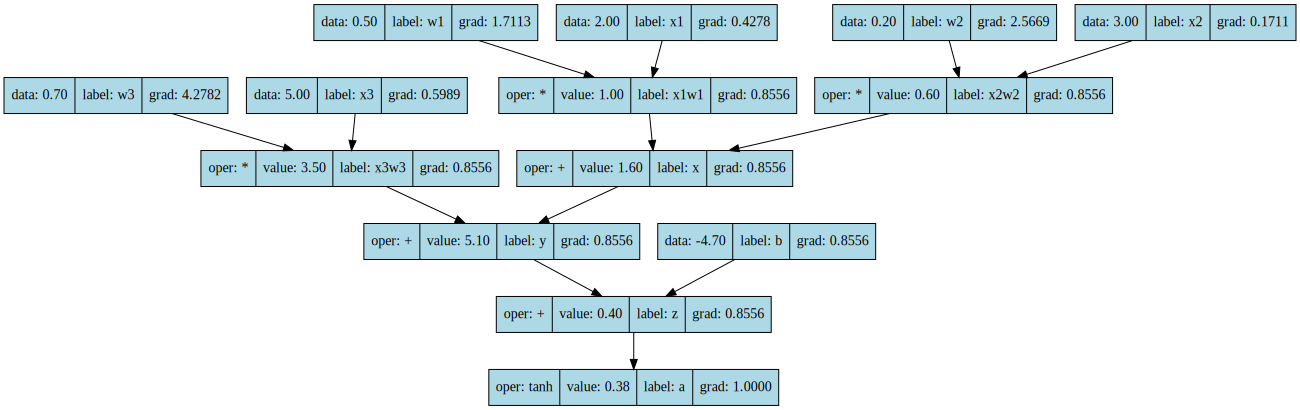

In [ ]:
dot = draw_computation_graph(a)
display(dot)

In [ ]:
a.grad = 1
z.grad = 0
y.grad = 0
b.grad = 0
x.grad = 0
x3w3.grad = 0
x2w2.grad = 0
x1w1.grad = 0
w3.grad = 0
w2.grad = 0
w1.grad = 0
x1.grad = 0
x2.grad = 0
x3.grad = 0

# METHOD 4
## Implementing the topological sorting technique in the Value class then calling the .backward() on the last node.

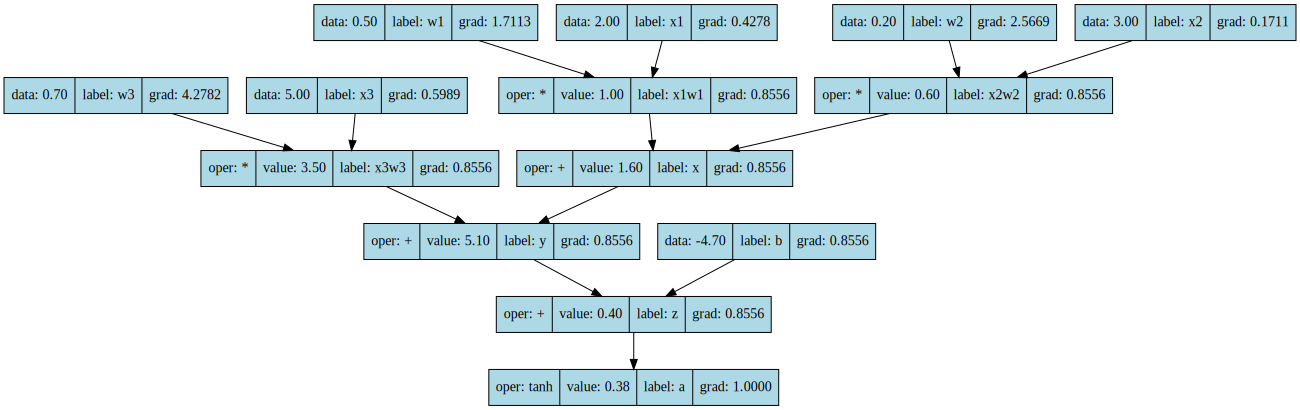

In [ ]:
a.backward()
dot = draw_computation_graph(a)
display(dot)